In [1]:
import numpy as np
import tensorflow as tf

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# you have to specify the type
A = tf.placeholder(tf.float32, shape=(5, 5), name='A')


# but shape and name are optional
v = tf.placeholder(tf.float32)


# I think this name is more appropriate than 'dot'
w = tf.matmul(A, v)

In [3]:
# similar to Theano, you need to "feed" the variables values.
# In TensorFlow you do the "actual work" in a "session".

with tf.Session() as session:
    # the values are fed in via the appropriately named argument "feed_dict"
    # v needs to be of shape=(5, 1) not just shape=(5,)
    # it's more like "real" matrix multiplication
    output = session.run(w, feed_dict={A: np.random.randn(5, 5), v: np.random.randn(5, 1)})

    # what's this output that is returned by the session? let's print it
    print(output, type(output))
    
    # luckily, the output type is just a numpy array. back to safety!

[[ 0.00472598]
 [-0.43340614]
 [ 0.05661434]
 [-0.58585685]
 [-0.39839315]] <class 'numpy.ndarray'>


In [4]:
# A tf variable can be initialized with a numpy array or a tf array
# or more correctly, anything that can be turned into a tf tensor
shape = (2, 2)
x = tf.Variable(tf.random_normal(shape))
# x = tf.Variable(np.random.randn(2, 2))
t = tf.Variable(0) # a scalar

In [5]:
# you need to "initialize" the variables first
init = tf.global_variables_initializer()

In [6]:
with tf.Session() as session:
    out = session.run(init) # and then "run" the init operation
    print(out) # it's just None

    # eval() in tf is like get_value() in Theano
    print(x.eval()) # the initial value of x
    print(t.eval())

None
[[-1.0526377   0.4078191 ]
 [-0.66109604 -1.5805446 ]]
0


In [8]:
# let's now try to find the minimum of a simple cost function like we did in Theano
u = tf.Variable(20.0)
cost = u*u + u + 1.0

# One difference between Theano and TensorFlow is that you don't write the updates
# yourself in TensorFlow. You choose an optimizer that implements the algorithm you want.
# 0.3 is the learning rate. Documentation lists the params.
train_op = tf.train.GradientDescentOptimizer(0.3).minimize(cost)

In [11]:
# let's run a session again
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    # Strangely, while the weight update is automated, the loop itself is not.
    # So we'll just call train_op until convergence.
    # This is useful for us anyway since we want to track the cost function.
    for i in range(12):
        session.run(train_op)
        print("i = %d, cost = %.3f, u = %.3f" % (i, cost.eval(), u.eval()))

i = 0, cost = 67.990, u = 7.700
i = 1, cost = 11.508, u = 2.780
i = 2, cost = 2.471, u = 0.812
i = 3, cost = 1.025, u = 0.025
i = 4, cost = 0.794, u = -0.290
i = 5, cost = 0.757, u = -0.416
i = 6, cost = 0.751, u = -0.466
i = 7, cost = 0.750, u = -0.487
i = 8, cost = 0.750, u = -0.495
i = 9, cost = 0.750, u = -0.498
i = 10, cost = 0.750, u = -0.499
i = 11, cost = 0.750, u = -0.500


In [12]:
def error_rate(p, t):
    return np.mean(p != t)

In [14]:
from util import get_normalized_data, y2indicator

# step 1: get the data and define all the usual variables
X, Y = get_normalized_data()

max_iter = 15
print_period = 10

lr = 0.00004
reg = 0.01

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

# add an extra layer just for fun
M1 = 300
M2 = 100
K = 10
W1_init = np.random.randn(D, M1) / 28
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2)
b3_init = np.zeros(K)

Reading in and transforming data...


In [15]:
# define variables and expressions
X = tf.placeholder(tf.float32, shape=(None, D), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))

In [16]:
# define the model
Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
Yish = tf.matmul(Z2, W3) + b3 # remember, the cost function does the softmaxing! weird, right?

In [17]:
# softmax_cross_entropy_with_logits take in the "logits"
# if you wanted to know the actual output of the neural net,
# you could pass "Yish" into tf.nn.softmax(logits)
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=Yish, labels=T))

In [20]:
# we choose the optimizer but don't implement the algorithm ourselves
# let's go with RMSprop, since we just learned about it.
# it includes momentum!
train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)

# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

In [21]:
costs = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={X: Xtest})
                err = error_rate(prediction, Ytest)
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                costs.append(test_cost)



Cost / err at iteration i=0, j=0: 2411.788 / 0.921
Cost / err at iteration i=0, j=10: 1586.887 / 0.351
Cost / err at iteration i=0, j=20: 881.479 / 0.218
Cost / err at iteration i=0, j=30: 552.248 / 0.150
Cost / err at iteration i=0, j=40: 418.609 / 0.121
Cost / err at iteration i=0, j=50: 354.205 / 0.108
Cost / err at iteration i=0, j=60: 309.814 / 0.094
Cost / err at iteration i=0, j=70: 281.038 / 0.084
Cost / err at iteration i=0, j=80: 258.173 / 0.072
Cost / err at iteration i=1, j=0: 253.879 / 0.071
Cost / err at iteration i=1, j=10: 238.339 / 0.067
Cost / err at iteration i=1, j=20: 226.287 / 0.065
Cost / err at iteration i=1, j=30: 213.087 / 0.061
Cost / err at iteration i=1, j=40: 202.742 / 0.059
Cost / err at iteration i=1, j=50: 194.987 / 0.058
Cost / err at iteration i=1, j=60: 185.012 / 0.056
Cost / err at iteration i=1, j=70: 176.488 / 0.054
Cost / err at iteration i=1, j=80: 168.628 / 0.047
Cost / err at iteration i=2, j=0: 166.704 / 0.045
Cost / err at iteration i=2, j=1

NameError: name 'plt' is not defined

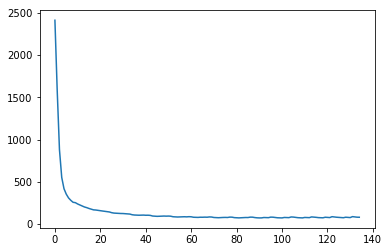

In [22]:
import matplotlib.pyplot as plt

plt.plot(costs)
plt.show()
# increase max_iter and notice how the test cost starts to increase.
# are we overfitting by adding that extra layer?
# how would you add regularization to this model?